# Customer fraud regression

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation

# Increase memory for driver and executor
spark = SparkSession.builder \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Read in the transaction data and consumer fraud data
transaction_1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")

# Union the transactions data
transactions = transaction_1.union(transaction_2).union(transaction_3)

consumer_fraud = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True, inferSchema=True)

# Aggregate transactions to get total spending and number of orders per customer per day
daily_transactions = transactions.groupBy("user_id", "order_datetime") \
                                 .agg(F.sum("dollar_value").alias("total_spent"), 
                                      F.count("order_id").alias("num_orders"))

# Join the aggregated transactions with the fraud probability data
fraud_data = daily_transactions.join(consumer_fraud, ["user_id", "order_datetime"], how="left")

# Join the aggregated transactions with the fraud probability data
fraud_data_full = daily_transactions.join(consumer_fraud, ["user_id", "order_datetime"])

# Convert to Pandas DataFrame for plotting
fraud_data_pd = fraud_data_full.toPandas()

/Users/ngoc/Desktop/project-2-group-buy-now-pay-later-industry-project-6/myenv/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


# Customer fraud's plots

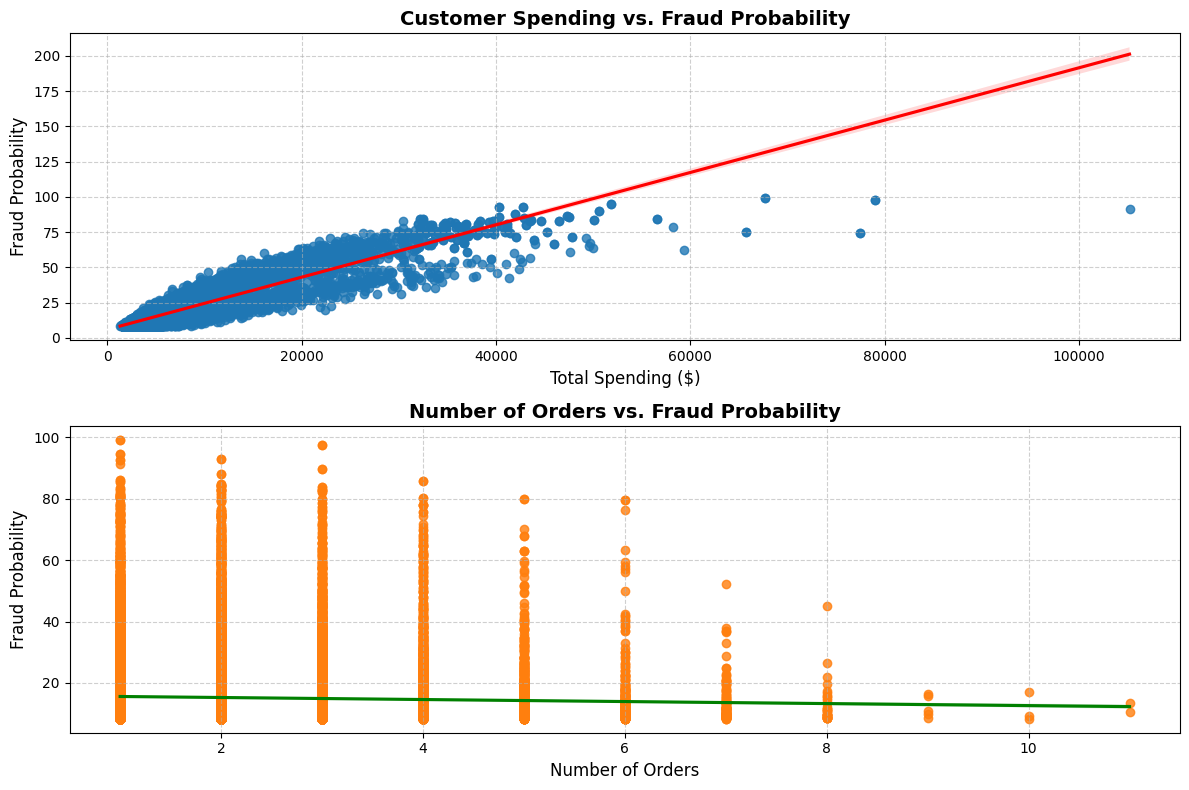

In [18]:
# Create the plot with total spending and number of orders against fraud probability
plt.figure(figsize=(12, 8))

# Plot 1: Total spending vs. Fraud probability
plt.subplot(2, 1, 1)  # First subplot
sns.regplot(x='total_spent', y='fraud_probability', data=fraud_data_pd, 
            scatter_kws={"color": "#1f77b4"}, line_kws={"color": "red"})
plt.title('Customer Spending vs. Fraud Probability', fontsize=14, fontweight='bold')
plt.xlabel('Total Spending ($)', fontsize=12)
plt.ylabel('Fraud Probability', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Number of orders vs. Fraud probability
plt.subplot(2, 1, 2)  # Second subplot
sns.regplot(x='num_orders', y='fraud_probability', data=fraud_data_pd, 
            scatter_kws={"color": "#ff7f0e"}, line_kws={"color": "green"})
plt.title('Number of Orders vs. Fraud Probability', fontsize=14, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Fraud Probability', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Layout adjustments and saving the figure
plt.tight_layout()
plt.savefig('../plots/customer_fraud_analysis.png', dpi=300)
plt.show()

# Linear Regression modeling

## Prepare the data

In [19]:
from pyspark.sql import functions as F

# Feature engineering in Spark
fraud_data = fraud_data.withColumn('total_spent_per_order', fraud_data['total_spent'] / fraud_data['num_orders']) \
                       .withColumn('total_spent_squared', fraud_data['total_spent'] ** 2) \
                       .withColumn('num_orders_squared', fraud_data['num_orders'] ** 2)

fraud_data = fraud_data.withColumn('fraud_probability', F.col('fraud_probability') / 100)

## Step wise selection with AIC

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
import math

# Ensure there are no null or NaN labels
fraud_data_clean = fraud_data.filter(F.col('fraud_probability').isNotNull())
fraud_data_clean = fraud_data_clean.filter(~F.isnan(F.col('fraud_probability')))

# Rename the fraud_probability column to 'label' for training
fraud_data_clean = fraud_data_clean.withColumnRenamed('fraud_probability', 'label')

# Split data into train and test sets
train_data, test_data = fraud_data_clean.randomSplit([0.7, 0.3], seed=42)

# List of predictors
predictors = ['total_spent', 'num_orders', 'total_spent_per_order', 'total_spent_squared', 'num_orders_squared']

# Initialize variables for iterative model selection
current_predictors = predictors.copy()
best_aic = float('inf')
best_model = None
improvement = True

def compute_log_likelihood(predictions):
    """Compute log-likelihood for linear regression"""
    eps = 1e-15  # To avoid log(0)
    residuals = predictions.rdd.map(lambda row: row['label'] - row['prediction'])
    mse = residuals.map(lambda x: x ** 2).mean()
    log_likelihood = -0.5 * residuals.count() * (math.log(2 * math.pi * mse) + 1)
    return log_likelihood

def compute_aic(log_likelihood, num_parameters):
    """Calculate AIC based on log-likelihood and number of parameters"""
    return 2 * num_parameters - 2 * log_likelihood

# Iteratively remove predictors and evaluate model using AIC
while improvement and len(current_predictors) > 0:
    aic_with_predictors = {}
    models = {}
    
    for predictor in current_predictors:
        features = [p for p in current_predictors if p != predictor]
        
        # Assemble features
        assembler = VectorAssembler(inputCols=features, outputCol='features')
        train_prepared = assembler.transform(train_data)
        
        # Fit linear regression model
        lr = LinearRegression(featuresCol='features', labelCol='label')
        lr_model = lr.fit(train_prepared)
        
        # Get predictions and compute AIC
        test_prepared = assembler.transform(test_data)
        predictions = lr_model.transform(test_prepared)
        
        # Compute log-likelihood
        log_likelihood = compute_log_likelihood(predictions)
        
        # Number of parameters (including intercept)
        num_parameters = len(features) + 1
        aic = compute_aic(log_likelihood, num_parameters)
        
        # Store AIC and model
        aic_with_predictors[predictor] = aic
        models[predictor] = (lr_model, features)
    
    # Find the predictor whose removal gives the lowest AIC
    best_predictor_to_remove = min(aic_with_predictors, key=aic_with_predictors.get)
    best_aic_candidate = aic_with_predictors[best_predictor_to_remove]
    
    if best_aic_candidate < best_aic:
        # Update best AIC and remove the predictor
        best_aic = best_aic_candidate
        current_predictors.remove(best_predictor_to_remove)
        best_model = models[best_predictor_to_remove][0]
        best_features = models[best_predictor_to_remove][1]
        print(f"Removed predictor: {best_predictor_to_remove}, New AIC: {best_aic}")
    else:
        # No improvement, stop the loop
        print("No further improvement in AIC. Stopping.")
        improvement = False

# Make predictions with the best model
assembler = VectorAssembler(inputCols=best_features, outputCol='features')
test_prepared = assembler.transform(test_data)
predictions = best_model.transform(test_prepared)

# Print final model coefficients and intercept
print(f"Coefficients: {best_model.coefficients}")
print(f"Intercept: {best_model.intercept}")

# Evaluate final model using R-squared and MSE
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

final_rmse = evaluator_rmse.evaluate(predictions)
final_r2 = evaluator_r2.evaluate(predictions)

24/09/30 01:25:15 WARN Instrumentation: [13392669] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:25:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/30 01:25:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/09/30 01:25:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/09/30 01:26:00 WARN Instrumentation: [5f449c79] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:26:41 WARN Instrumentation: [b9df61cd] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:27:16 WARN Instrumentation: [d0952144] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:27:56 WARN Instrumentation: [79b043ec] regParam is zero, which might cause numerical instability and overfitting.


Removed predictor: num_orders_squared, New AIC: -37396.775647346454


24/09/30 01:28:38 WARN Instrumentation: [395e8dcd] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:29:14 WARN Instrumentation: [e0210676] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:29:45 WARN Instrumentation: [8a90af56] regParam is zero, which might cause numerical instability and overfitting.
24/09/30 01:30:15 WARN Instrumentation: [4880b3a6] regParam is zero, which might cause numerical instability and overfitting.


No further improvement in AIC. Stopping.
Coefficients: [2.1024185870267962e-05,0.004225839295005643,6.339509795704176e-06,-1.7964698551680922e-10]
Intercept: 0.02887091670909327


# Evaluate the final model

In [21]:
print(f"Final RMSE: {final_rmse}")
print(f"R-squared: {final_r2}")

Final RMSE: 0.03937496193948661
R-squared: 0.8454224083392797


In [22]:
# Print final model coefficients and intercept
# Print the final selected predictors (features) and their corresponding coefficients
print("Selected Predictors and their Coefficients:")
for feature, coeff in zip(best_features, best_model.coefficients):
    print(f"{feature}: {coeff}")
print(f"Intercept: {best_model.intercept}")

Selected Predictors and their Coefficients:
total_spent: 2.1024185870267962e-05
num_orders: 0.004225839295005643
total_spent_per_order: 6.339509795704176e-06
total_spent_squared: -1.7964698551680922e-10
Intercept: 0.02887091670909327


# Imputation for records having no consumer fraud probability

In [23]:
from pyspark.sql.functions import when, col

# Identify rows where fraud_probability is missing
missing_fraud_data = fraud_data.filter(F.col("fraud_probability").isNull())

# Feature engineering for the missing data
missing_fraud_data = missing_fraud_data.withColumn('total_spent_per_order', F.col('total_spent') / F.col('num_orders')) \
                                       .withColumn('total_spent_squared', F.col('total_spent') ** 2)

# Compute fraud_probability using the trained model's intercept and coefficients
# Using the updated coefficients from the final model
intercept_value = 0.0288709167090932
coefficients = {
    'total_spent': 2.1024185870267955e-05,
    'num_orders': 0.004225839295005758,
    'total_spent_per_order': 6.3395097957041775e-06,
    'total_spent_squared': -1.7964698551680911e-10
}

# Apply the trained model's formula for fraud_probability
missing_fraud_data = missing_fraud_data.withColumn('predicted_fraud_probability',
    intercept_value +
    coefficients['total_spent'] * F.col('total_spent') + 
    coefficients['num_orders'] * F.col('num_orders') +
    coefficients['total_spent_per_order'] * F.col('total_spent_per_order') +
    coefficients['total_spent_squared'] * F.col('total_spent_squared')
)

# Update the original fraud_data with the imputed fraud_probability
fraud_data = fraud_data.alias("original").join(
    missing_fraud_data.select("user_id", "order_datetime", "predicted_fraud_probability").alias("predicted"),
    on=["user_id", "order_datetime"],
    how="left"
)

# Use coalesce to fill in missing fraud_probability values with the predicted ones
fraud_data_updated = fraud_data.withColumn(
    'fraud_probability',
    F.coalesce(F.col('original.fraud_probability'), F.col('predicted.predicted_fraud_probability'))
)

In [24]:
# Final updated DataFrame with imputed fraud_probability values
fraud_data_updated.select("user_id", "order_datetime", "fraud_probability").show()

+-------+--------------+--------------------+
|user_id|order_datetime|   fraud_probability|
+-------+--------------+--------------------+
|    686|    2021-08-20| 0.04292299909593163|
|    778|    2021-08-20| 0.03888098420394133|
|    786|    2021-08-20| 0.03529272132749612|
|   1205|    2021-08-20|0.040105763662395745|
|   1491|    2021-08-20| 0.04126109344497197|
|   1691|    2021-08-20|0.042851016693242705|
|   1693|    2021-08-20|0.049841940957622316|
|   2243|    2021-08-20|   0.053400967874804|
|   2647|    2021-08-20| 0.03806888737783047|
|   2716|    2021-08-20| 0.04057001931297796|
|   2727|    2021-08-20|0.035890940421878785|
|  18488|    2021-08-20|0.052359873381422346|
|  19292|    2021-08-20| 0.05924878914424941|
|  19476|    2021-08-20| 0.04953550016345344|
|  19497|    2021-08-20| 0.04179671235358186|
|  19628|    2021-08-20| 0.04749339990374517|
|  19631|    2021-08-20|0.033530044587772465|
|  19672|    2021-08-20| 0.04289699815746831|
|  20431|    2021-08-20| 0.0332667

# Merchant Fraud analysis

## Check the percentage of merchants present in merchant_fraud

In [25]:
merchants = spark.read.parquet("../data/curated/curated_merchants")
merchants_fraud = pd.read_csv("../data/tables/merchant_fraud_probability.csv")

In [26]:
# Get unique merchant_abn count in merchants_fraud
unique_merchant_fraud_count = merchants_fraud['merchant_abn'].nunique()

# Get the total count of merchants in the merchants dataframe
total_merchants_count = merchants.select('merchant_abn').distinct().count()

# Calculate the percentage
percentage_merchants_with_fraud_data = (unique_merchant_fraud_count / total_merchants_count) * 100

print(f"Percentage of merchants with fraud data: {percentage_merchants_with_fraud_data:.2f}%")

Percentage of merchants with fraud data: 1.55%


## Exploratory plotting

/Users/ngoc/Desktop/project-2-group-buy-now-pay-later-industry-project-6/myenv/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/ngoc/Desktop/project-2-group-buy-now-pay-later-industry-project-6/myenv/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


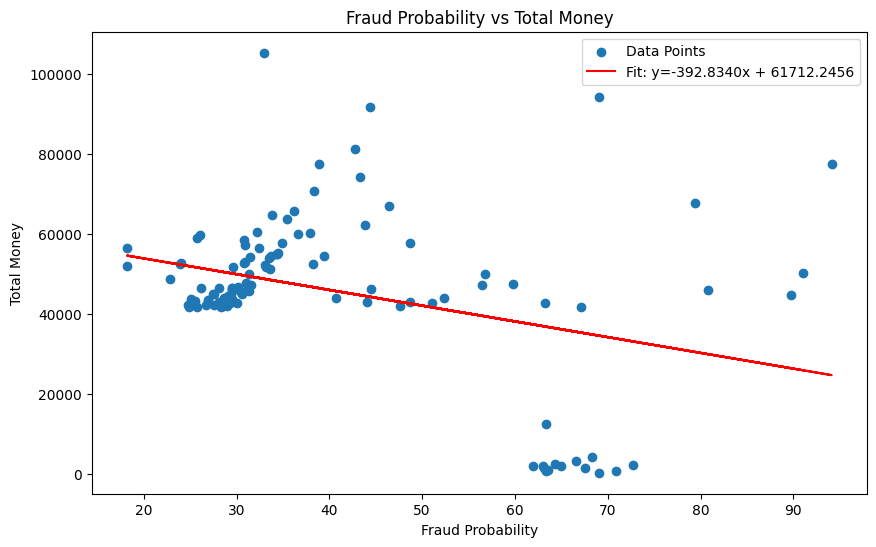

In [27]:
import numpy as np

# Load the merchant_fraud CSV into a Spark DataFrame
merchant_fraud_spark = spark.createDataFrame(merchants_fraud)

# Perform the join on both merchant_abn and order_datetime to ensure uniqueness
joined_data = transactions.alias("tra").join(
    merchant_fraud_spark.alias("fra"), 
    (F.col("tra.merchant_abn") == F.col("fra.merchant_abn")) & 
    (F.col("tra.order_datetime") == F.col("fra.order_datetime")), 
    how="inner"
)

# Perform aggregation and include fraud_probability in the result
merchant_stats = joined_data.groupBy("tra.merchant_abn", "tra.order_datetime", "fra.fraud_probability") \
                            .agg(
                                F.sum("tra.dollar_value").alias("total_money"),
                                F.count("tra.order_id").alias("num_transactions"),
                                (F.sum("tra.dollar_value") / F.count("tra.order_id")).alias("avg_transaction_value")
                            )

# Convert the merchant_stats Spark DataFrame to Pandas for plotting
merchant_stats_pd = merchant_stats.toPandas()

# Function to plot scatter and linear fit line
def plot_with_fit(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data Points')
    
    # Fit a linear line (y = mx + b)
    m, b = np.polyfit(x, y, 1)  # 1 means linear fit (degree = 1)
    plt.plot(x, m * x + b, color='red', label=f'Fit: y={m:.4f}x + {b:.4f}')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot a: fraud_probability vs total_money
plot_with_fit(merchant_stats_pd['fraud_probability'], merchant_stats_pd['total_money'], 
              'Fraud Probability', 'Total Money', 'Fraud Probability vs Total Money')

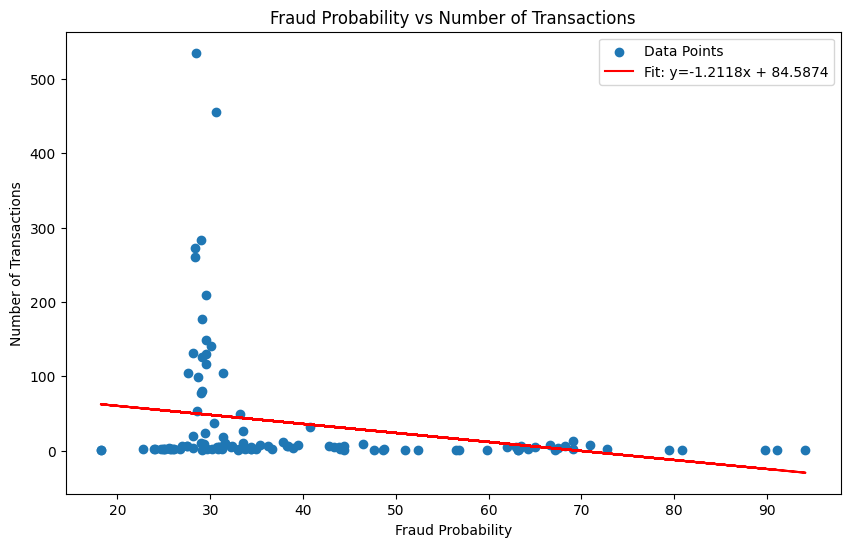

In [28]:
# Plot b: fraud_probability vs num_transactions
plot_with_fit(merchant_stats_pd['fraud_probability'], merchant_stats_pd['num_transactions'], 
              'Fraud Probability', 'Number of Transactions', 'Fraud Probability vs Number of Transactions')

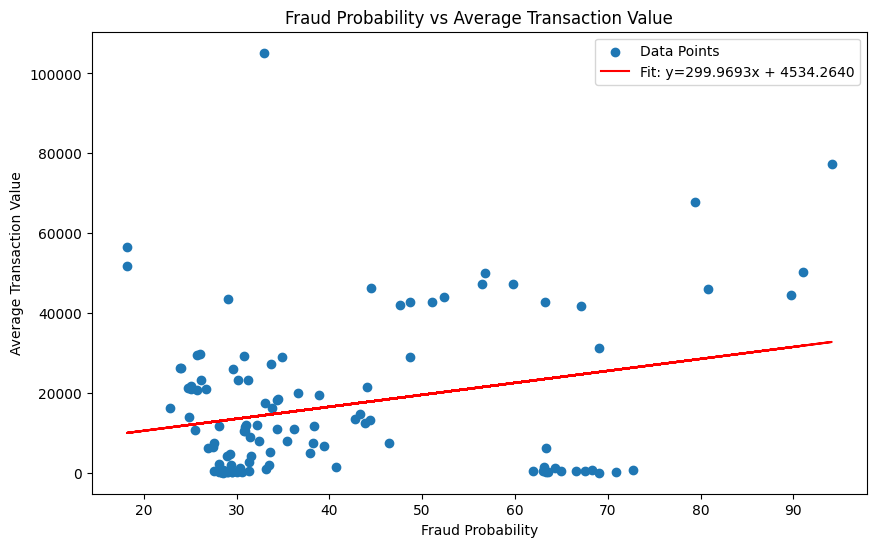

In [29]:
# Plot c: fraud_probability vs avg_transaction_value
plot_with_fit(merchant_stats_pd['fraud_probability'], merchant_stats_pd['avg_transaction_value'], 
              'Fraud Probability', 'Average Transaction Value', 'Fraud Probability vs Average Transaction Value')

# Check correlations

In [30]:
from pyspark.sql.functions import corr

# Compute correlation between fraud_probability and total_money
corr_fraud_total_money = merchant_stats.select(corr("fraud_probability", "total_money")).collect()[0][0]

# Compute correlation between fraud_probability and num_transactions
corr_fraud_num_transactions = merchant_stats.select(corr("fraud_probability", "num_transactions")).collect()[0][0]

# Compute correlation between fraud_probability and avg_transaction_value
corr_fraud_avg_transaction_value = merchant_stats.select(corr("fraud_probability", "avg_transaction_value")).collect()[0][0]

# Print the correlations
print(f"Correlation between fraud_probability and total_money: {corr_fraud_total_money}")
print(f"Correlation between fraud_probability and num_transactions: {corr_fraud_num_transactions}")
print(f"Correlation between fraud_probability and avg_transaction_value: {corr_fraud_avg_transaction_value}")

Correlation between fraud_probability and total_money: -0.34115417788462227
Correlation between fraud_probability and num_transactions: -0.2464516340691899
Correlation between fraud_probability and avg_transaction_value: 0.2673609612684381


## Decision tree model to impute fraud probability

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F

# Prepare the features and label from 'merchant_stats'
assembler = VectorAssembler(inputCols=['total_money', 'num_transactions'], 
                            outputCol='features')

# Transform the data into feature vectors
data_prepared = assembler.transform(merchant_stats)

# Initialize the Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='fraud_probability')

# Set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 4]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

# Set up 5-fold CrossValidator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='fraud_probability', predictionCol='prediction', metricName='rmse'),
                          numFolds=5)

# Split the data into train and test sets (90% train, 10% test)
train_data, test_data = data_prepared.randomSplit([0.9, 0.1], seed=42)

# Train the model using cross-validation
cv_model = crossval.fit(train_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Evaluate the model performance
evaluator = RegressionEvaluator(labelCol='fraud_probability', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol='fraud_probability', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# Get the best model parameters
best_model = cv_model.bestModel
print(f"Best maxDepth: {best_model.getMaxDepth()}")
print(f"Best maxBins: {best_model.getMaxBins()}")

RMSE: 6.046683793780371
R-squared: 0.8115129482946885
Best maxDepth: 2
Best maxBins: 64


# Impute combinations of merchant_abn and date that don't have fraud probability

In [32]:
# Get all combinations of merchant_abn and order_datetime from transactions
all_combinations = transactions.select("merchant_abn", "order_datetime").distinct()

# Join with merchants_fraud to find the missing fraud_probabilities
missing_combinations = all_combinations.join(
    merchant_fraud_spark, 
    on=["merchant_abn", "order_datetime"], 
    how="left"
)

# Identify the rows where fraud_probability is missing (fraud_probability is null)
missing_fraud_data = missing_combinations.filter(F.col("fraud_probability").isNull())

# For these missing combinations, perform the same aggregation to get total_money and num_transactions
missing_merchant_stats = missing_fraud_data.join(
    transactions, 
    on=["merchant_abn", "order_datetime"], 
    how="inner"
).groupBy("merchant_abn", "order_datetime") \
.agg(
    F.sum("dollar_value").alias("total_money"),
    F.count("order_id").alias("num_transactions")
)

# Prepare the feature vector for the missing data
assembler = VectorAssembler(inputCols=['total_money', 'num_transactions'], outputCol='features')
missing_data_prepared = assembler.transform(missing_merchant_stats)

# Use the trained decision tree model to predict fraud probabilities for the missing data
predictions = cv_model.transform(missing_data_prepared)

# Add the predicted fraud_probability to the missing combinations
missing_fraud_imputed = missing_merchant_stats.join(
    predictions.select("merchant_abn", "order_datetime", "prediction"), 
    on=["merchant_abn", "order_datetime"], 
    how="inner"
).withColumnRenamed("prediction", "imputed_fraud_probability")

# Combine the imputed fraud probabilities with the original merchant_fraud data
# First, filter out the rows in `merchant_fraud` where fraud_probability is not missing
existing_fraud_data = merchant_fraud_spark.filter(F.col("fraud_probability").isNotNull())

# Now union the imputed fraud data with the existing fraud data
final_merchant_fraud = existing_fraud_data.unionByName(
    missing_fraud_imputed.select("merchant_abn", "order_datetime", "imputed_fraud_probability").withColumnRenamed("imputed_fraud_probability", "fraud_probability")
)

# Verify the final dataset contains all the combinations of merchant_abn and order_datetime
final_merchant_fraud.show()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
| 31334588839|    2021-12-26| 38.36165958070444|
| 23686790459|    2021-12-10|  79.4543441508535|
| 14827550074|    2021-11-26| 46.45775596795885|
| 31334588839|    2021-11-26| 36.20971272078342|
| 19492220327|    2021-12-18|33.819672154331755|
| 31334588839|    2021-11-29|35.386213297375505|
| 14827550074|    2021-12-05| 43.85519494291279|
| 19492220327|    2021-11-18|32.193139919494016|
| 93260930990|    2021-11-30| 37.87197154172081|
| 90918180829|    2021-09-16| 36.62001350882694|
| 83199298021|    2022-02-27|26.025158824861773|
| 83199298021|    2022-02-17| 25.77998392496447|
| 94311056026|    20

In [33]:
final_merchant_fraud = final_merchant_fraud.drop("order_datetime")
final_merchant_fraud.show(3)

+------------+------------------+
|merchant_abn| fraud_probability|
+------------+------------------+
| 19492220327|44.403658647495355|
| 31334588839| 42.75530083865367|
| 19492220327|38.867790051131095|
+------------+------------------+
only showing top 3 rows



# Get the average fraud rate for every merchants

In [34]:
# Convert DataFrame to RDD
rdd = final_merchant_fraud.rdd.map(lambda row: (row['merchant_abn'], (row['fraud_probability'], 1)))

# Use reduceByKey to sum fraud probabilities and counts per merchant
sum_counts = rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Compute the mean fraud probability per merchant_abn
merchant_fraud_mean_rdd = sum_counts.mapValues(lambda x: x[0] / x[1])

# Convert back to DataFrame if needed
merchant_fraud_mean = merchant_fraud_mean_rdd.toDF(["merchant_abn", "mean_fraud_probability"])

# Show the results
merchant_fraud_mean.show()

+------------+----------------------+
|merchant_abn|mean_fraud_probability|
+------------+----------------------+
| 21439773999|     32.53321204787232|
| 10165489824|    59.715004920401555|
| 10463252268|     64.77377242516685|
| 10487253336|      65.9077340298432|
| 11208869091|     64.77377242516685|
| 11215815177|     64.59162864215584|
| 11355018654|     66.06523086546206|
| 11452293720|     64.77377242516688|
| 11700214701|     65.00795258378986|
| 12578813079|     64.77377242516685|
| 12870663624|     69.41835488815609|
| 12899341959|     64.79711203553369|
| 13226823813|      64.7737724251669|
| 13565102775|     69.41835488815607|
| 14522297874|     64.77377242516684|
| 14639489823|     67.62665337511555|
| 15560455575|     69.17412518206199|
| 15912561882|      69.3263829581959|
| 15937271532|     64.77377242516688|
| 16096277862|     64.84122486757546|
+------------+----------------------+
only showing top 20 rows



# Export processed fraud data

In [35]:
# Save the 'merchant_fraud_mean' DataFrame to Parquet
merchant_fraud_mean.write.mode("overwrite").parquet("../data/curated/merchant_fraud_all.parquet")

# Save the 'fraud_data_updated' DataFrame to Parquet
fraud_data_updated.select("user_id", "order_datetime", "fraud_probability") \
    .write.mode("overwrite").parquet("../data/curated/user_fraud_n_spending_by_date.parquet")

